In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from pyproj import Transformer, CRS
from shapely import box
import reprojection
import os

In [2]:
datasets = []

for file in os.listdir("data"):
    path = os.path.join("data", file)
    try:
        datasets.append(reprojection.reproject_CO(path))
    except (ValueError) as e:
        print(f"Warning file {file}: {e}")
        continue

Warning file S5P_OFFL_L2__CO_____20240704T234334_20240705T012503_34853_03_020600_20240706T171442.nc.zip: numpy.nanmin raises on a.size==0 and axis=None; So Bottleneck too.
Warning file S5P_OFFL_L2__CO_____20240708T002754_20240708T020923_34896_03_020600_20240709T141638.nc.zip: numpy.nanmin raises on a.size==0 and axis=None; So Bottleneck too.
Warning file S5P_OFFL_L2__CO_____20240717T005917_20240717T024046_35024_03_020600_20240719T053959.nc.zip: numpy.nanmin raises on a.size==0 and axis=None; So Bottleneck too.
Warning file S5P_OFFL_L2__CO_____20240706T010600_20240706T024730_34868_03_020600_20240707T145404.nc.zip: numpy.nanmin raises on a.size==0 and axis=None; So Bottleneck too.
Warning file S5P_OFFL_L2__CO_____20240723T004617_20240723T022746_35109_03_020600_20240724T143359.nc.zip: numpy.nanmin raises on a.size==0 and axis=None; So Bottleneck too.
Warning file S5P_OFFL_L2__CO_____20240704T000237_20240704T014407_34839_03_020600_20240705T134546.nc.zip: numpy.nanmin raises on a.size==0 an

In [3]:
merged = reprojection.merge_mean_by_time(datasets)
merged

<xarray.Dataset> Size: 5MB
Dimensions:                                (time: 30, y: 60, x: 90)
Coordinates:
  * x                                      (x) float64 720B 4.5e+06 ... 5.39e+06
  * y                                      (y) float64 480B 1.79e+06 ... 1.2e+06
  * time                                   (time) datetime64[s] 240B 2024-07-...
Data variables:
    qa_value                               (time, y, x) float64 1MB nan ... nan
    carbonmonoxide_total_column            (time, y, x) float64 1MB nan ... nan
    carbonmonoxide_total_column_precision  (time, y, x) float64 1MB nan ... nan
    carbonmonoxide_total_column_corrected  (time, y, x) float64 1MB nan ... nan

In [14]:
path = "/home/otto/s1_zarr/s5p/data/S5P_OFFL_L2__CO_____20240709T101748_20240709T115918_34916_03_020600_20240711T024017.nc.zip"
ds = xr.open_dataset(path, engine="netcdf4")#, group = "PRODUCT")

In [15]:
ds

<xarray.Dataset> Size: 0B
Dimensions:  ()
Data variables:
    *empty*
Attributes: (12/52)
    Conventions:                        CF-1.7
    institution:                        KNMI/SRON
    source:                             Sentinel 5 precursor, TROPOMI, space-...
    history:                            2024-07-11 05:39:34 f_s5pops tropnll2...
    summary:                            TROPOMI/S5P CO Column 1-Orbit L2 Swat...
    tracking_id:                        17b41b45-c454-4aca-8f78-73d25d2db9b0
    ...                                 ...
    title:                              TROPOMI/S5P CO Column 1-Orbit L2 Swat...
    product_version:                    1.5.0
    processing_status:                  Nominal
    Status_MET_2D:                      Nominal
    Status_CTM_CO:                      Nominal
    Status_CTMCH4:                      Nominal

In [18]:
transformer = Transformer.from_crs("EPSG:27704", "EPSG:4326", always_xy=True)
x,y = 5700000, 2100000
lon_max, lat_max = transformer.transform(x, y)
x,y = 4200000, 900000
lon_min, lat_min = transformer.transform(x,y)

austria_bbox = box(lon_min, lat_min, lon_max, lat_max)

In [ ]:
ds = ds.load()
ds = ds.set_coords(["longitude", "latitude"])
delta_time  = ds[["delta_time", "latitude", "longitude"]]

ds = ds.drop_vars(["delta_time", "time_utc"])

In [20]:
mask = (
    (ds["latitude"] >= lat_min) & (ds["latitude"] <= lat_max) &
    (ds["longitude"] >= lon_min) & (ds["longitude"] <= lon_max) & 
    (ds["qa_value"] >= 0.5)
)

ds_subset = ds.where(mask, drop=True) 

In [21]:
ds_subset = ds_subset.rio.write_crs("EPSG:4326", inplace=False)

In [22]:
ds_band = ds_subset.squeeze()
ds_band

<xarray.Dataset> Size: 240B
Dimensions:                                (time: 0, scanline: 0,
                                            ground_pixel: 0, corner: 4,
                                            layer: 50)
Coordinates:
  * scanline                               (scanline) float64 0B 
  * ground_pixel                           (ground_pixel) float64 0B 
  * time                                   (time) datetime64[ns] 0B 
  * corner                                 (corner) float64 32B 0.0 1.0 2.0 3.0
  * layer                                  (layer) float32 200B 4.95e+04 ... ...
    latitude                               (time, scanline, ground_pixel) float32 0B ...
    longitude                              (time, scanline, ground_pixel) float32 0B ...
    spatial_ref                            int64 8B 0
Data variables:
    qa_value                               (time, scanline, ground_pixel) float32 0B ...
    carbonmonoxide_total_column            (time, scanline, ground_pixel) float32 0B ...
    carbonmonoxide_total_column_precision  (time, scanline, ground_pixel) float32 0B ...
    carbonmonoxide_total_column_corrected  (time, scanline, ground_pixel) float32 0B ...

In [8]:
lat_original = ds_band["latitude"]
lon_original = ds_band["longitude"]

In [9]:
lat_min, lat_max = lat_original.min().item(), lat_original.max().item()
lon_min, lon_max = lon_original.min().item(), lon_original.max().item()
lat_min, lat_max, lon_min, lon_max

(36.368961334228516, 56.402801513671875, 3.190840721130371, 26.536487579345703)

In [10]:
target_resolution = 0.1

n_points_lat_full = int(np.ceil((lat_max - lat_min) / target_resolution)) + 1
n_points_lon_full = int(np.ceil((lon_max - lon_min) / target_resolution)) + 1
target_lat_full = np.linspace(lat_min, lat_max, n_points_lat_full)
target_lon_full = np.linspace(lon_min, lon_max, n_points_lon_full)
lon_grid_full, lat_grid_full = np.meshgrid(target_lon_full, target_lat_full)

In [11]:
gridded_data = {}

for var in ds_band.data_vars:
    gridded = griddata((lon_original.values.flatten(), lat_original.values.flatten()),
                                    ds_band[var].values.flatten(),
                                    (lon_grid_full, lat_grid_full),
                                    method="linear")

    gridded_data[var] = gridded

In [12]:
import numpy as np
import rasterio
from rasterio.transform import from_origin
from rasterio.warp import calculate_default_transform, reproject, Resampling

def reproject_numpy_to_equi7_eu_1km(
    data, lons, lats, nodata=np.nan, resampling="bilinear"
):

    assert data.ndim == 2 and data.shape == (len(lats), len(lons))

    if lats[0] < lats[-1]:
        data = data[::-1, :]
        lats = lats[::-1]

    xres = float(abs(lons[1] - lons[0]))
    yres = float(abs(lats[1] - lats[0]))
    west = float(lons.min())
    north = float(lats.max())
    src_transform = from_origin(west - xres/2, north + yres/2, xres, yres)
    src_crs = "EPSG:4326"

    dst_crs = "EPSG:27704"
    out_res = 10000.0

    left, bottom, right, top = rasterio.transform.array_bounds(
        data.shape[0], data.shape[1], src_transform
    )
    dst_transform, dst_w, dst_h = calculate_default_transform(
        src_crs, dst_crs, data.shape[1], data.shape[0],
        left, bottom, right, top, resolution=out_res
    )

    from math import floor
    x0 = floor(dst_transform.c / out_res) * out_res
    y0 = floor(dst_transform.f / out_res) * out_res
    dst_transform = rasterio.Affine(out_res, 0, x0, 0, -out_res, y0)

    dst = np.full((dst_h, dst_w), nodata, dtype=data.dtype)
    reproject(
        source=data,
        destination=dst,
        src_transform=src_transform,
        src_crs=src_crs,
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        resampling=getattr(Resampling, resampling),
        src_nodata=nodata,
        dst_nodata=nodata,
    )
    return dst, dst_transform, dst_crs

In [13]:
reprojected = {}

for var in gridded_data:
    arr_10km, tr_1km, crs_1km = reproject_numpy_to_equi7_eu_1km(
        gridded_data[var], target_lon_full, target_lat_full,
        nodata=np.nan,                 # or np.nan for floats
        resampling="bilinear"          # use "nearest" for labels; "bilinear"/"cubic" for continuous
    )

    reprojected[var] = (("y", "x"),arr_10km)#.reshape(1,arr_10km.shape[0], arr_10km.shape[1]))

In [15]:
def pixel_center_coords(transform, width, height):
    """
    Returns 2D arrays X, Y with the projected coordinates
    of each pixel center given an affine transform.
    """
    # Column indices (0..width-1)
    cols = np.arange(width)
    # Row indices (0..height-1)
    rows = np.arange(height)

    # Convert pixel indices to map coords (center positions)
    xs = transform.c + cols * transform.a + transform.b * 0
    ys = transform.f + rows * transform.e + transform.d * 0

    # Meshgrid to 2D arrays
    #X, Y = np.meshgrid(xs, ys)
    return xs, ys

# Example usage after reprojection:
# arr_1km, tr_1km, crs_1km = reproject_numpy_to_equi7_eu_1km(...)
xs, ys = pixel_center_coords(tr_1km, arr_10km.shape[1], arr_10km.shape[0])

# print(X.shape, Y.shape)   # both (rows, cols)
# print(X.min(), X.max())   # extent in x
# print(Y.min(), Y.max())   # extent in y

In [32]:
sensing_time = delta_time["delta_time"].values[0][0].astype("datetime64[D]")

In [ ]:
ds_equi7 = xr.Dataset(reprojected,
                      coords={
                              "x":("x", xs),
                              "y":("y", ys),
                              })

In [36]:
ds_aut = ds_equi7.sel(x=slice(4500000,5390000), y=slice(1790000,1200000)).expand_dims({"time": [sensing_time]})

In [40]:
transformer = Transformer.from_crs("EPSG:27704", "EPSG:4326", always_xy=True)
x,y = 5400000, 1800000
lon_max, lat_max = transformer.transform(x, y)
x,y = 4500000, 1200000
lon_min, lat_min = transformer.transform(x,y)

In [45]:
X, Y = np.meshgrid(ds_aut["x"].values, ds_aut["y"].values)
lons_new, lats_new = transformer.transform(X,Y)

In [48]:
X, Y = np.meshgrid(ds_equi7["x"].values, ds_equi7["y"].values)
lons_new_equi, lats_new_equi = transformer.transform(X,Y)

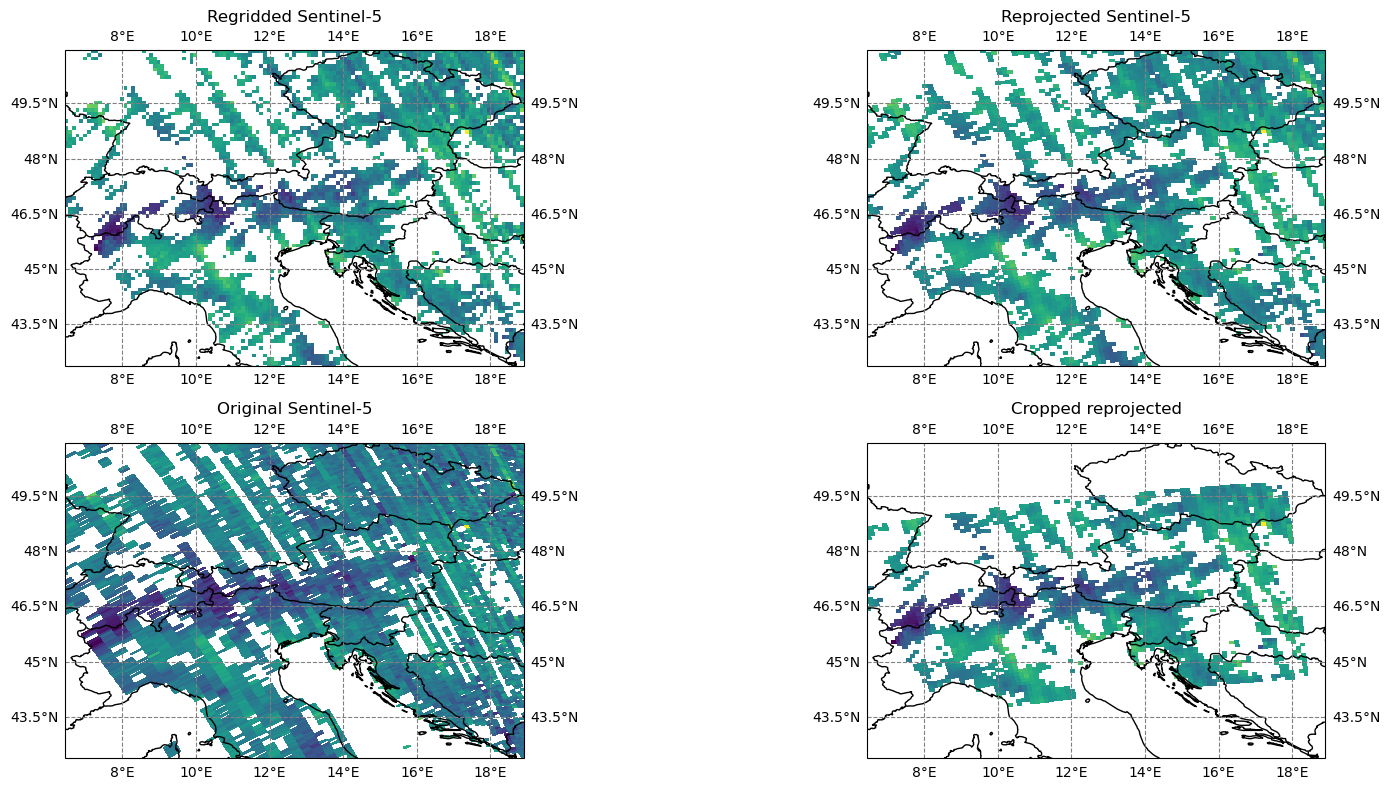

In [50]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(17, 8), subplot_kw={"projection": ccrs.PlateCarree()})

axs=axs.flatten()
axs[0].pcolormesh(lon_grid_full, lat_grid_full, gridded_data["carbonmonoxide_total_column"], cmap="viridis")#, vmin=-2, vmax=1)
axs[3].pcolormesh(lons_new, lats_new, ds_aut["carbonmonoxide_total_column"].squeeze(), transform=ccrs.PlateCarree(), cmap="viridis")#, vmin=-2, vmax=1)
axs[2].pcolormesh(lon_original, lat_original, ds_band["carbonmonoxide_total_column"], cmap="viridis")#, vmin=-2, vmax=1)
axs[1].pcolormesh(lons_new_equi, lats_new_equi, ds_equi7["carbonmonoxide_total_column"], cmap="viridis")#, vmin=-2, vmax=1)

for ax in axs:
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)

    ax.gridlines(draw_labels=True, color="gray", linestyle="--")
    ax.set_xlim(lon_min-1, lon_max+1)
    ax.set_ylim(lat_min-1, lat_max+1)

axs[0].set_title("Regridded Sentinel-5")
axs[1].set_title("Reprojected Sentinel-5")
axs[2].set_title("Original Sentinel-5")
axs[3].set_title("Cropped reprojected")

plt.tight_layout()
plt.show()